# Physics-informed Thermoacoustic Neural Networks
Authors: D. E. Ozan & L. Magri

In thermoacoustic systems, if the heat release is sufficiently in phase with pressure, *thermoacoustic oscillations* occur.\
For background information on the field, see
* Magri, L., Adjoint methods as design tools in thermoacoustics, Applied Mechanics Reviews (2019), 71(2), 020801.
* Magri, L., Schmid, P. J. & Moeck, J. P. , Linear flow analysis inspired by mathematical methods from quantum mechanics, Annual Review of Fluid Mechanics (2023), 55, doi: 10.1146/annurev-fluid-031022-044209

Typical nonlinear regimes are limit cycles, quasiperiodic, and chaotic oscillations. 

In this notebook, we will develop a neural network that models **acoustic pressure and velocity fluctuations** from a prototypical thermoacoustic system, *Rijke tube*, as a **function of time and space**. 

![Galerkin Neural Network](images/rijke_schematic.png)

This work is from
* ​Ozan, D.E. & Magri, L., Physics-aware learning of nonlinear limit cycles and adjoint limit cycles, Inter-noise (2022), Glasgow.
* Ozan, Defne Ege, & Magri, Luca, Hard- and soft-constrained thermoacoustic neural networks, (2023), https://doi.org/10.5281/zenodo.7538880

### Outline
1. Importing and preprocessing data
2. Setting up the Galerkin neural network \
    2.1 Temporal branch \
    2.2 Spatial branch
3. Setting up the physics-informed loss function
4. Training 
5. Postprocessing and visualisation

In [1]:
import numpy as np
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split as interp_train_val_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer
from scipy.optimize import root_scalar
from pathlib import Path

In [2]:
# Flag to whether to train a network or load pretrained weights
train_network = False
# Flag to whether both pressure and velocity, or just pressure, or just velocity is observed
observe = "both" # 'both','p','u'
# Noise level on the data
noise_std = 0
# Folder directory
log_dir = Path(f"logs/galnn_quasi_observe_{observe}_noise_{noise_std}")

### Plotting functions

In [3]:
def surf(fig, ax, X, Y, ZZ, xlabel, ylabel, zlabel):
    """
    Plot surfaces in 3D given X,Y,Z data

    Args:
    X, Y: X, Y data on 1d grid
    ZZ: Z data on 2d grid
    """
    [XX, YY] = np.meshgrid(X, Y)  # create 2d grid
    surf1 = ax.plot_surface(
        XX,
        YY,
        ZZ,
        rstride=1,
        cstride=1,
        cmap="coolwarm",
        linewidth=0,
        antialiased=False,
    )
    fig.colorbar(surf1, shrink=0.5, aspect=10, pad = 0.1)
    ax.set_title(zlabel)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_2d(ax,X,Y_idx,X_true,Y_idx_true,idx_train,Z,Z_true,Z_pred,
    xlabel,zlabel,title,axis,add_legend=True,add_inset=False,inset_x_lim=None,inset_y_lim=None):
    if axis == 0:
        if Z is not None:
            ax.scatter(X[idx_train], Z[Y_idx, idx_train], color="red", s=20, zorder = 2)
        if Z_true is not None:
            ax.plot(X_true, Z_true[Y_idx_true, :], color="black", zorder = 1)
        if Z_pred is not None:
            ax.plot(X_true,Z_pred[Y_idx_true, :],color="limegreen",linestyle="--",zorder = 1)
    else:
        if Z is not None:
            ax.scatter(X[idx_train], Z[idx_train, Y_idx], color="red", s=20, zorder = 2)
        if Z_true is not None:
            ax.plot(X_true, Z_true[:, Y_idx_true], color="black", zorder = 1)
        if Z_pred is not None:
            ax.plot(X_true,Z_pred[:, Y_idx_true],color="limegreen",linestyle="--",zorder = 1)       
    ax.set_xlabel(xlabel)
    ax.set_ylabel(zlabel)
    ax.set_title(title)
    ax.grid()
    if add_legend is True:
        legend_list = []
        if Z is not None:
            legend_list.append("Train")
        if Z_true is not None:
            legend_list.append("True")
        if Z_pred is not None:
            legend_list.append("Prediction")
        ax.legend(legend_list,loc="upper left", fontsize = 14)
    if add_inset:
        inset_axes1 = ax.inset_axes([0.5, 0.05, 0.45, 0.45])
        if axis == 0:
            if Z is not None:
                inset_axes1.scatter(X[idx_train], Z[Y_idx, idx_train], color="red", s=20, zorder = 2)
            if Z_true is not None:
                inset_axes1.plot(X_true, Z_true[Y_idx_true, :], color="black", zorder = 1)
            if Z_pred is not None:
                inset_axes1.plot(X_true,Z_pred[Y_idx_true, :],color="limegreen",linestyle="--",zorder = 1)
        else:
            if Z is not None:
                inset_axes1.scatter(X[idx_train], Z[idx_train, Y_idx], color="red", s=20, zorder = 2)
            if Z_true is not None:
                inset_axes1.plot(X_true, Z_true[:, Y_idx_true], color="black", zorder = 1)
            if Z_pred is not None:
                inset_axes1.plot(X_true,Z_pred[:, Y_idx_true],color="limegreen",linestyle="--",zorder = 1)
        inset_axes1.set_xticks([])
        inset_axes1.set_yticks([])
        inset_axes1.set_xlim(inset_x_lim)
        inset_axes1.set_ylim(inset_y_lim)

## Import data

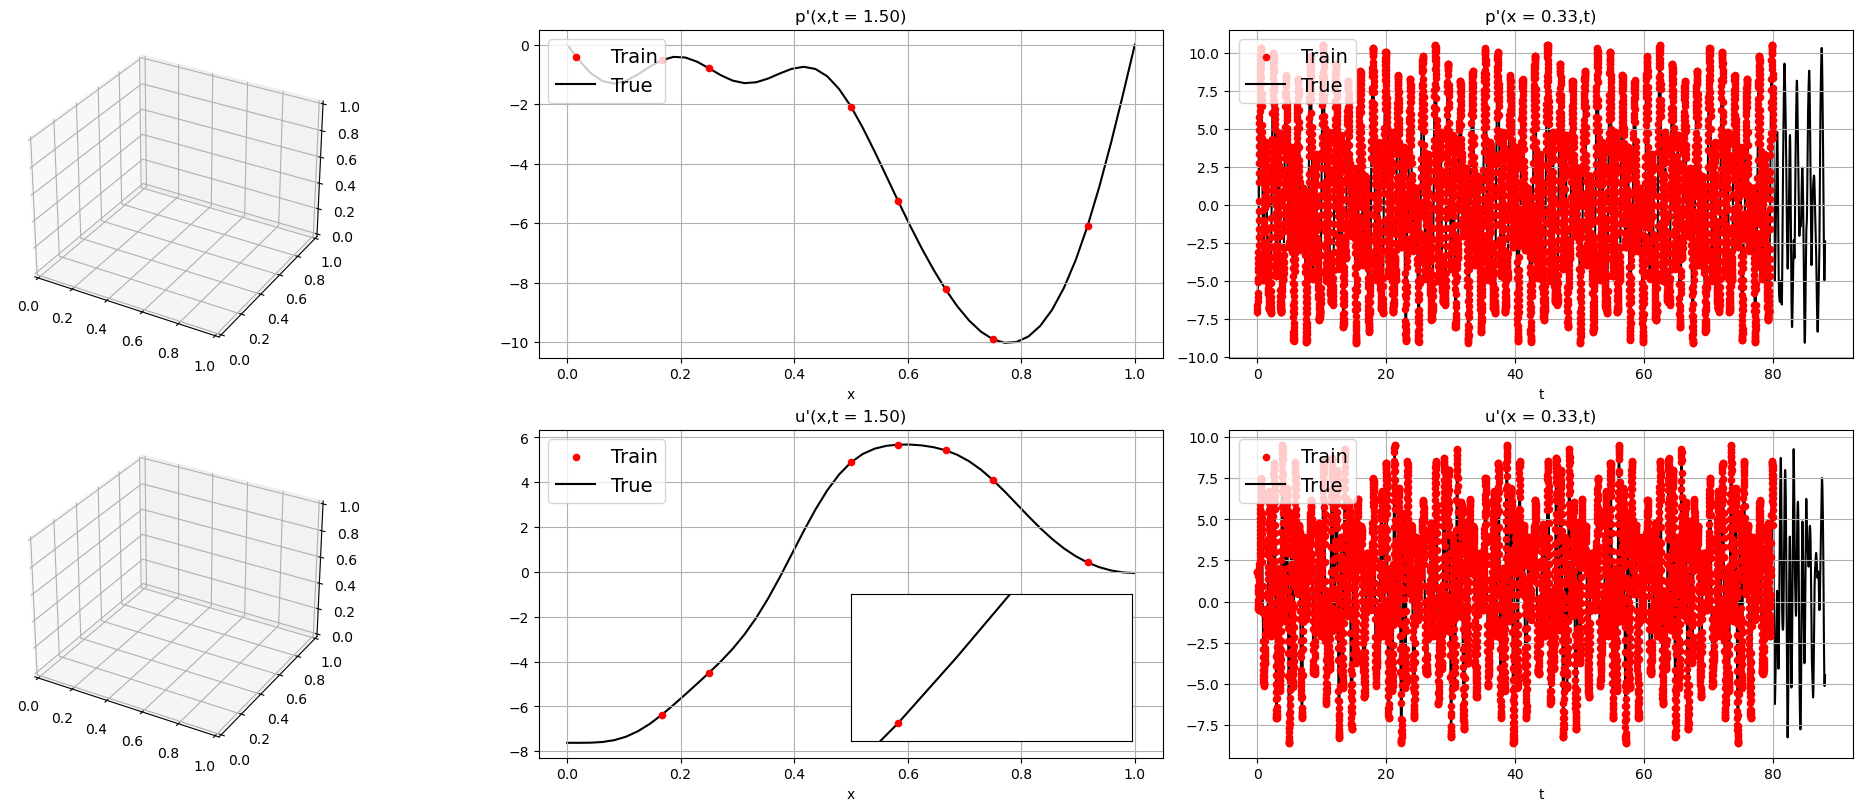

In [4]:
# load preprocessed data (nondimensional, transient removed)
with open("data/quasi_data_dict.pickle", "rb") as handle:
    true_data_dict = pickle.load(handle)

# copy the data dict and create the training data
data_dict = true_data_dict.copy()

# choose grid 
x_idx = np.arange(0,len(true_data_dict["x"]),4)
x_idx = x_idx[1:-1]
data_dict["x"] = data_dict["x"][x_idx]
data_dict["P"] = data_dict["P"][:,x_idx]
data_dict["U"] = data_dict["U"][:,x_idx]

# add noise
rand_P = np.random.RandomState(seed = 1)
sigma_P = np.std(data_dict["P"])
W_P = rand_P.normal(loc=0.0, scale=(noise_std/100)*sigma_P, size=data_dict["P"].shape)

rand_U = np.random.RandomState(seed = 2)
sigma_U = np.std(data_dict["U"])
W_U = rand_U.normal(loc=0.0, scale=(noise_std/100)*sigma_U, size=data_dict["U"].shape)

data_dict["P"] = data_dict["P"] + W_P
data_dict["U"] = data_dict["U"] + W_U

# split into train and validation sets
dt = data_dict["t"][1] - data_dict["t"][0]
train_length = 80
val_length = 8

N_train = int(np.ceil(train_length / dt)) + 1
N_val = int(np.ceil(val_length / dt)) + 1
for key in ["t", "P", "U"]:
    data_dict[key+"_train"] = data_dict[key][:N_train]
    data_dict[key+"_val"] = data_dict[key][N_train : N_train + N_val]
    true_data_dict[key+"_train"] = true_data_dict[key][:N_train]
    true_data_dict[key+"_val"] = true_data_dict[key][N_train : N_train + N_val]

# create input output datasets that can be fed into the network
def create_input_output(x, t, P, U):
    """Create input and output data from the data given on a grid
    'true' refers to noise-free data
    """
    [xx, tt] = np.meshgrid(x, t)
    x_data = xx.flatten()
    t_data = tt.flatten()
    P_data = P.flatten()
    U_data = U.flatten()
    input = np.hstack((x_data[:, None], t_data[:, None]))
    output = np.hstack((P_data[:, None], U_data[:, None]))
    return input, output

input_train_full, output_train_full = create_input_output(
        data_dict["x"],
        data_dict["t_train"],
        data_dict["P_train"],
        data_dict["U_train"],
    )   

# validation for interpolation split
interp_val_split = 0.2
idx_train_full = np.arange(len(input_train_full))
(input_train, 
    input_val_interp,
    output_train, 
    output_val_interp,
    idx_train,
    idx_val_interp,
) = interp_train_val_split(
    input_train_full,
    output_train_full,
    idx_train_full,
    test_size=interp_val_split,
    random_state=3,
)

# validation for extrapolation set
input_val_extrap, output_val_extrap = create_input_output(
        data_dict["x"],
        data_dict["t_val"],
        data_dict["P_val"],
        data_dict["U_val"],
    )
    
# create tf datasets for the training
train_dataset = None
val_interp_dataset = None
val_extrap_dataset = None

# prepare the training dataset
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, output_train))
# shuffle and divide in batches
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)  

# prepare the validation (interpolation) dataset
val_interp_dataset = tf.data.Dataset.from_tensor_slices((input_val_interp, output_val_interp))
val_interp_dataset = val_interp_dataset.shuffle(buffer_size=1024).batch(batch_size)  

# prepare the validation (extrapolation) dataset
val_extrap_dataset = tf.data.Dataset.from_tensor_slices((input_val_extrap, output_val_extrap))
val_extrap_dataset = val_extrap_dataset.shuffle(buffer_size=1024).batch(batch_size) 

P_stack_true = np.vstack([true_data_dict["P_train"], true_data_dict["P_val"]])
U_stack_true = np.vstack([true_data_dict["U_train"], true_data_dict["U_val"]])
t_stack_true = np.hstack([true_data_dict["t_train"], true_data_dict["t_val"]])

## Visualise imported data
# find the time index to plot
t_plot = 1.5
dt_true = true_data_dict["t_train"][1] - true_data_dict["t_train"][0]
t_idx_true = int(np.ceil(t_plot / dt_true))

dt = data_dict["t_train"][1] - data_dict["t_train"][0]
t_idx = int(np.ceil(t_plot / dt))

# find the spatial index to plot
x_plot = 1/3
dx_true = true_data_dict["x"][1] - true_data_dict["x"][0]
x_idx_true = int(np.round((x_plot - true_data_dict["x"][0]) / dx_true))

dx = data_dict["x"][1] - data_dict["x"][0]
x_idx = int(np.round((x_plot - data_dict["x"][0]) / dx))

# unravel train indices and pass those that match with the time index we wish to plot
# for our data P_train and U_train have the same shape, so it doesn't matter whose shape we use to unravel
# however if they are given on different grids, then the code should also be modified
idx_train_unraveled = np.unravel_index(idx_train, data_dict["P_train"].shape)
idx_train_at_t_idx = idx_train_unraveled[1][idx_train_unraveled[0] == t_idx]
idx_train_at_x_idx = idx_train_unraveled[0][idx_train_unraveled[1] == x_idx]

# set if both, just pressure, just velocity was given
if observe == "both":
    Z_p_given = data_dict["P_train"]
    Z_u_given = data_dict["U_train"]
    observe_p = True
    observe_u = True
elif observe == "p":
    Z_p_given = data_dict["P_train"]
    Z_u_given = None
    observe_p = True
    observe_u = False
elif observe == "u":
    Z_p_given = None
    Z_u_given = data_dict["U_train"]
    observe_p = False 
    observe_u = True   

fig = plt.figure(figsize=(20,8), constrained_layout = True)
ax = fig.add_subplot(2, 3, 1, projection="3d")
#surf(fig, ax, true_data_dict["x"], true_data_dict["t_train"], true_data_dict["P_train"], "x", "t", "True p(x,t)")
ax = fig.add_subplot(2, 3, 2)
plot_2d(ax,X=data_dict["x"],X_true=true_data_dict["x"],Y_idx=t_idx,idx_train=idx_train_at_t_idx,Y_idx_true=t_idx_true,
    Z=Z_p_given,Z_true=true_data_dict["P_train"],Z_pred=None,
    xlabel="x",zlabel="",title=f"p'(x,t = {t_plot:.2f})",axis=0)
ax = fig.add_subplot(2, 3, 3)
plot_2d(ax,X=data_dict["t_train"],X_true=t_stack_true,Y_idx=x_idx,idx_train=idx_train_at_x_idx,Y_idx_true=x_idx_true,
    Z=Z_p_given,Z_true=P_stack_true,Z_pred=None,
    xlabel="t",zlabel="",title=f"p'(x = {x_plot:.2f},t)",axis=1)
ax = fig.add_subplot(2, 3, 4, projection="3d")
#surf(fig, ax, true_data_dict["x"], true_data_dict["t_train"], true_data_dict["U_train"], "x", "t", "True u(x,t)")
ax = fig.add_subplot(2, 3, 5)
plot_2d(ax,X=data_dict["x"],X_true=true_data_dict["x"],Y_idx=t_idx,idx_train=idx_train_at_t_idx,Y_idx_true=t_idx_true,
        Z=Z_u_given,Z_true=true_data_dict["U_train"],Z_pred=None,
        xlabel="x",zlabel="",title=f"u'(x,t = {t_plot:.2f})",axis=0,
        add_inset=True,inset_x_lim=[0.15, 0.25],inset_y_lim=[-6.5, -5.5])
ax = fig.add_subplot(2, 3, 6)
plot_2d(ax,X=data_dict["t_train"],X_true=t_stack_true,Y_idx=x_idx,idx_train=idx_train_at_x_idx,Y_idx_true=x_idx_true,
        Z=Z_u_given,Z_true=U_stack_true,Z_pred=None,
        xlabel="t",zlabel="",title=f"u'(x = {x_plot:.2f},t)",axis=1)

#fig = plt.figure(figsize=(3.5,3.5))
#plt.plot(true_data_dict["P_train"][:,x_idx],true_data_dict["U_train"][:,x_idx], color = 'black')
#plt.xlabel(f"p'(x = {x_plot:.2f},t)")
#plt.ylabel(f"u'(x = {x_plot:.2f},t)")
#plt.show()

## Set up neural network 

Inspired by Galerkin decomposition of thermoacoustics, our thermoacoustic neural network, Galerkin Neural Network or GalNN, separates the neural network into two branches, spatial and temporal. The physics of thermoacoustic are then hard-constrained in the spatial branch using an a priori chosen physical spatial basis.

![Galerkin Neural Network](images/galnn_new.png)

#### Create sine activation layer in the temporal branch for the general case

In [5]:
def sinx(x, a=5, dtype=tf.float32):
    """Define 1/a*sin(a*x) activation function"""
    a = tf.constant(a, dtype=dtype)
    return 1 / a * tf.sin(a * x)

def periodic_uniform(shape, dtype=tf.float32):
    """Weights initialization from a uniform distribution"""
    var = tf.constant(1 / shape[0], dtype=dtype)
    val = tf.sqrt(3 * var)
    return tf.random.uniform(shape, minval=-val, maxval=val, dtype=dtype)

### Create the model of temporal branch

In [6]:
# define the temporal branch as a tf sequential model
model = tf.keras.Sequential()

# define input layer, takes only time as input
model.add(tf.keras.layers.InputLayer(input_shape = 1, dtype = tf.float32))

# add the sine layer
N_neurons = 96 # number of neurons
model.add(tf.keras.layers.Dense(N_neurons,kernel_initializer=periodic_uniform,dtype=tf.float32))
model.add(tf.keras.layers.Activation(tf.keras.layers.Lambda(lambda x: sinx(x, 10))))

# add the sine layer
model.add(tf.keras.layers.Dense(N_neurons,kernel_initializer=periodic_uniform,dtype=tf.float32))
model.add(tf.keras.layers.Activation(tf.keras.layers.Lambda(lambda x: sinx(x, 10))))

# define output layer, gives Galerkin variables for both pressure and velocity as output
N_g = 10 # number of Galerkin modes
model.add(tf.keras.layers.Dense(2*N_g,activation = 'linear', dtype=tf.float32))
# for this data we don't need the jump modes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                192       
                                                                 
 activation (Activation)     (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 activation_1 (Activation)   (None, 96)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                1940      
                                                                 
Total params: 11,444
Trainable params: 11,444
Non-trainable params: 0
_________________________________________________________________


### Set up modal basis for the spatial branch
We solve a dispersion relationship using the mean flow densities and heat source location to obtain the physical spatial basis.

The acoustic angular frequencies $\omega_j$ are the solutions of the dispersion relationship, 
$\sin\beta_j\cos\gamma_j + \cos\beta_j\sin\gamma_j\sqrt{\frac{\bar{\rho}_1}{\bar{\rho}_2}} = 0$

$\gamma_j = \omega_j\sqrt{\bar{\rho}_1}x_f, \quad \beta_j = \omega_j\sqrt{\bar{\rho}_2}(1-x_f)$

$j = 1,2,\dots, N_g$ and $N_g$ is the number of Galerkin modes.

In [7]:
def dispersion(omega, rho_up, rho_down, x_f):
    """
    Dispersion relationship
    Used to determine the acoustic angular frequencies in the piece-wise
    formulation of the Galerkin modes
    
    Args:
    omega: acoustic angular frequency
    rho_up, rho_down: mean flow density in the up- and downstream regions
    x_f: heat source location

    Returns:
    f: dispersion relationship,
       equal to 0 for the acoustic angular frequencies of the system
    """
    gamma = omega * np.sqrt(rho_up) * x_f
    beta = omega * np.sqrt(rho_down) * (1 - x_f)
    f = np.sin(beta) * np.cos(gamma) + np.cos(beta) * np.sin(gamma) * np.sqrt(
        rho_up / rho_down
    )
    return f


def dispersion_d(omega, rho_up, rho_down, x_f):
    """
    Differential of the dispersion relationship
    """
    gamma = omega * np.sqrt(rho_up * x_f)
    beta = omega * np.sqrt(rho_down) * (1 - x_f)
    df_domega1 = (
        np.cos(beta)
        * np.cos(gamma)
        * (
            np.sqrt(rho_down) * (1 - x_f)
            + np.sqrt(rho_up / rho_down) * np.sqrt(rho_up) * x_f
        )
    )
    df_domega2 = (
        -np.sin(beta)
        * np.sin(gamma)
        * (
            np.sqrt(rho_up) * x_f
            + np.sqrt(rho_up / rho_down) * np.sqrt(rho_down) * (1 - x_f)
        )
    )
    df_domega = df_domega1 + df_domega2
    return df_domega

def solve_dispersion(N_g, rho_up, rho_down, x_f):
    """
    Solves the dispersion relationship and returns acoustic frequencies

    Args:
    N_g: number of Galerkin modes
    rho_up, rho_down: mean flow density in the up- and downstream regions
    x_f: heat source location

    Returns:
    omega: acoustic angular frequencies
    k_up, k_down: acoustic wavenumbers in the up- and downstream regions
    """
    omega = np.zeros(N_g, dtype=np.float32)
    omega0 = np.pi  # initialise the first angular frequency
    for j in range(N_g):
        # solve the dispersion relationship as a root-finding problem
        # the brackets restrict the domain of the solution
        sol = root_scalar(
            dispersion,
            x0=omega0,
            bracket=[omega0 - 2, omega0 + 2],
            args=(rho_up, rho_down, x_f),
            fprime=dispersion_d,
        )
        omega[j] = sol.root
        omega0 = omega[j] + np.pi  # initialise the next solution

    # pre-calculate wavenumbers etc that are used in the modes
    k_up = omega * np.sqrt(rho_up) # wavenumbers in upstream
    k_down = omega * np.sqrt(rho_down) # wavenumbers in downstream
    gamma = k_up * x_f
    beta = k_down * (1 - x_f)
    if rho_up == 1.0 and rho_down == 1.0:
        upsilon = np.empty((N_g,), dtype=np.float32)
        upsilon[::2] = 1
        upsilon[1::2] = -1
    else:
        upsilon = np.sin(gamma) / np.sin(beta)

    return omega, k_up, k_down, upsilon

x_f = data_dict["mean_flow_dict"]["x_f"]
rho_up = data_dict["mean_flow_dict"]["rho_up"]
rho_down = data_dict["mean_flow_dict"]["rho_down"]
omega, k_up, k_down, upsilon = solve_dispersion(N_g, rho_up, rho_down, x_f)

print("Acoustic angular frequencies: ", omega)

def acoustic_modes(N_g, rho_up, rho_down, x_f, x):
    """
    Construct the piece-wise Galerkin modes
    See Magri, 2014 for the formulation

    Args:
    N_g: number of Galerkin modes
    omega: acoustic angular frequency
    rho_up, rho_down: mean flow density in the up- and downstream regions
    x_f: heat source location
    x: spatial coordinates, 1 x N_x

    Returns:
    Psi: pressure modes, N_g x N_x
    Phi: velocity modes, N_g+1 x N_x
    """
    # Determine the acoustic frequencies
    _, k_up, k_down, upsilon = solve_dispersion(N_g, rho_up, rho_down, x_f)

    # Find the indices for up- and downstream regions
    up_idx = np.where(x <= x_f)[0]
    down_idx = np.where(x > x_f)[0]

    # Pressure modes
    Psi_up = -np.sin(np.outer(k_up, x[up_idx]))
    Psi_down = -upsilon[:, None] * np.sin(np.outer(k_down, (1 - x[down_idx])))
    Psi = np.hstack((Psi_up, Psi_down))

    # Velocity modes
    Phi_up = 1 / np.sqrt(rho_up) * np.cos(np.outer(k_up, x[up_idx]))
    Phi_down = (
        -1
        / np.sqrt(rho_down)
        * upsilon[:, None]
        * np.cos(np.outer(k_down, (1 - x[down_idx])))
    )
    Phi = np.hstack((Phi_up, Phi_down))

    return Psi, Phi

Acoustic angular frequencies:  [ 3.1415927  6.2831855  9.424778  12.566371  15.707963  18.849556
 21.991148  25.132742  28.274334  31.415926 ]


### Combine the temporal and spatial branches in the predict step
The Galerkin decomposition of pressure and velocity are given as a linear combination of their acoustic eigenfunctions. 

$p'(x,t) = \sum_{j=1}^{N_g}\begin{cases}
-\mu_j(t)\sin(\omega_j\sqrt{\bar{\rho}_1}x), \quad 0\leq x \leq x_f, \\
-\mu_j(t)\left(\frac{\sin\gamma_j}{\sin\beta_j}\right)\sin(\omega_j\sqrt{\bar{\rho}_2}(1-x)), \quad x_f\leq x \leq 1, \\
\end{cases}$

$u'(x,t) = \sum_{j=1}^{N_g}\begin{cases}
\eta_j(t)\frac{1}{\sqrt{\bar{\rho}_1}}\cos(\omega_j\sqrt{\bar{\rho}_1}x), \quad 0\leq x \leq x_f, \\
-\eta_j(t)\frac{1}{\sqrt{\bar{\rho}_2}}\left(\frac{\sin\gamma_j}{\sin\beta_j}\right)\cos(\omega_j\sqrt{\bar{\rho}_2}(1-x)), \quad x_f\leq x \leq 1
\end{cases}$ 

For the formulation, see
* Magri, L. & Juniper, M. P., Global modes, receptivity, and sensitivity analysis of diffusion flames coupled with duct acoustics, Journal of Fluid Mechanics (2014), vol. 752, pp. 237-265.

To better capture the discontinuity and avoid oscillations in the predictions, we add two new spatial modes in the velocity modes which are defined as,
$\Psi_{0,1}(x) = \begin{cases}
1, \quad 0\leq x \leq x_f, \\
0, \quad x_f < x \leq 1, \\
\end{cases}$

$\Psi_{0,2}(x) = \begin{cases}
0, \quad 0\leq x < x_f, \\
1, \quad x_f\leq x \leq 1. \\
\end{cases}$

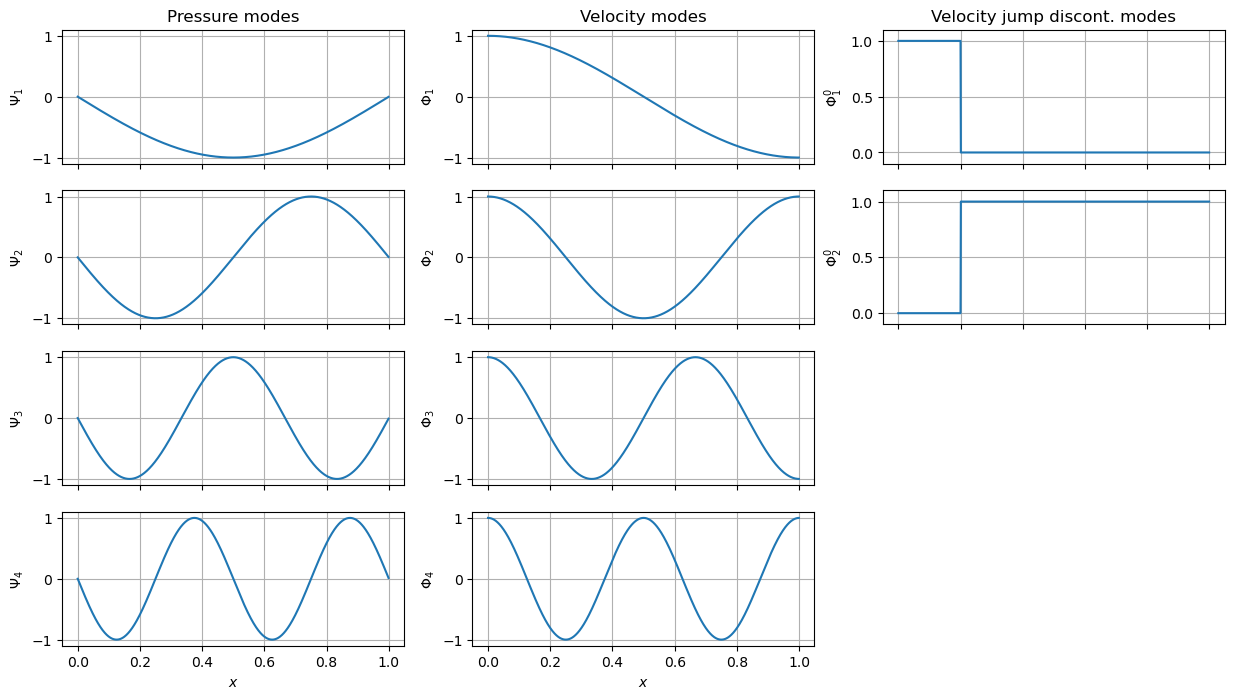

In [8]:
def jump_modes(x, x_f):
    # Find the indices for up- and downstream regions
    up_idx = np.where(x <= x_f)[0]
    down_idx = np.where(x > x_f)[0]
    # Add the zeroth mode, omega_0 = 0
    Phi_0_1_up = np.ones((1, len(x[up_idx])))
    Phi_0_1_down = np.zeros((1, len(x[down_idx])))
    Phi_0_1 = np.hstack((Phi_0_1_up, Phi_0_1_down))
    Phi_0_2_up = np.zeros((1, len(x[up_idx])))
    Phi_0_2_down = np.ones((1, len(x[down_idx])))
    Phi_0_2 = np.hstack((Phi_0_2_up, Phi_0_2_down))
    Phi_0 = np.vstack((Phi_0_1, Phi_0_2))
    return Phi_0

x = np.arange(0, 1, 0.001)
Psi, Phi = acoustic_modes(N_g, rho_up, rho_down, x_f, x)
Phi_0 = jump_modes(x, x_f)

def mode_plot(ax, x, modes, n_plt_modes, label, ylim):
    for j in range(0, n_plt_modes):
        ax[j].plot(x, modes[j, :])
        ax[j].set_ylim(ylim)
        ax[j].set_ylabel(f"${label}_{j+1}$")
        ax[j].tick_params(axis="x")
        ax[j].tick_params(axis="y")
        ax[j].grid()
    ax[-1].set_xlabel("$x$")

fig = plt.figure(figsize = (15,8))
ax = fig.subplots(4, 3, sharex=True)
mode_plot(ax[:,0], x, Psi, 4, "\Psi", ylim = [-1.1, 1.1])
ax[0,0].set_title("Pressure modes")
mode_plot(ax[:,1], x, Phi, 4, "\Phi", ylim = [-1.1, 1.1])
ax[0,1].set_title("Velocity modes")
mode_plot(ax[:,2], x, Phi_0, 2, "\Phi^0", ylim = [-0.1, 1.1])
ax[0,2].set_title("Velocity jump discont. modes")
ax[2,2].set_axis_off()
ax[3,2].set_axis_off()
plt.show()

In [9]:
@tf.function
def predict(input, training):
    """ Predict Galerkin variables from time and space.
    Compute pressure and velocity.

    Args:
        input: input to the Galerkin neural network
            vector of [x,t]
        training: flag if this step is used for training
    """
    # split inputs
    x = input[:, 0]
    t = input[:, 1]
    t = t[:, None]

    # predict galerkin coefficients
    y_pred = model(t, training=training)
    mu_pred = y_pred[:, 0 : N_g]
    eta_pred = y_pred[:, N_g : 2 * N_g + 2]

    # find pressure and velocity
    up_idx = x <= x_f  # condition array for the upstream section
    up_idx = up_idx[:, None]
    up_idx_0 = up_idx
    up_idx = tf.repeat(up_idx, N_g, axis=1)  # repeat the condition N_g times
    down_idx = x > x_f  # condition array for the downstream section
    down_idx = down_idx[:, None]
    down_idx_0 = down_idx
    down_idx = tf.repeat(down_idx, N_g, axis=1)  # repeat the condition N_g times

    # pressure modes in the up- and downstream
    p_up_modes = -tf.sin(tf.tensordot(x, k_up, axes=0))
    p_down_modes = -upsilon * tf.sin(tf.tensordot((1 - x), k_down, axes=0))

    # mask the modes so that only the modes that satisfy the x condition remain,
    # the rest is set to zero
    # note: in tf, can't assign values directly, e.g. p_modes[up_idx,:] = ... not allowed
    # that's why we use this workaround
    p_up_modes = tf.where(up_idx, p_up_modes, tf.zeros((input.shape[0], N_g)))
    p_down_modes = tf.where(down_idx, p_down_modes, tf.zeros((input.shape[0], N_g)))
    p_modes = p_up_modes + p_down_modes

    # velocity modes in the up- and downstream
    u_up_modes = (1 / rho_up**0.5) * tf.cos(tf.tensordot(x, k_up, axes=0))
    u_down_modes = -(1 / rho_down**0.5) * upsilon* tf.cos(tf.tensordot((1 - x), k_down, axes=0))

    # mask the modes again
    u_up_modes = tf.where(up_idx, u_up_modes, tf.zeros((input.shape[0], N_g)))
    u_down_modes = tf.where(down_idx, u_down_modes, tf.zeros((input.shape[0], N_g)))
    u_modes = u_up_modes + u_down_modes

    # 2 constant separate modes for jump 
    # u_mode_0 = tf.ones((input.shape[0], 1))
    # u_mode_0_1 = tf.where(up_idx_0, u_mode_0, tf.zeros((input.shape[0], 1)))
    # u_mode_0_2 = tf.where(down_idx_0, u_mode_0, tf.zeros((input.shape[0], 1)))
    # u_modes = tf.concat([u_mode_0_1, u_mode_0_2, u_modes], axis=1)
    
    # compute pressure and velocity from the modes
    p_pred = tf.reduce_sum(mu_pred * p_modes, axis=1)
    u_pred = tf.reduce_sum(eta_pred * u_modes, axis=1)
    p_pred = p_pred[:, None]
    u_pred = u_pred[:, None]
    output_pred = tf.concat([p_pred, u_pred], axis=1)
    return output_pred

### Evaluation of physics-informed loss

Physics of thermoacoustics are described by partial differential equations derived from

Conservation of momentum:
$\bar{\rho}\frac{\partial u'}{\partial t}+ \bar{u}\frac{\partial u'}{\partial x} + \frac{\partial p'}{\partial x} = 0$

Conservation of energy:
$\frac{\partial p'}{\partial t} +\bar{u}\frac{\partial p'}{\partial x} + \gamma\bar{p}\frac{\partial u'}{\partial x} = (\gamma-1)\dot{q}'\delta(x-x_f)$

The variables $p'$ and $u'$ are the acoustic pressure and velocity fluctuations, and $\dot{q}'$ is the heat release fluctuations from a mean flow. The heat release is assumed to be compact such that it is expressed with a dirac delta acting at the flame location $x_f$. In this case, we don't have knowledge of the heat release law, so we will only apply the left handside of the above equations in our physics-based loss. This is an additional soft-constraint that penalises solutions that violate the conservation laws.

In [10]:
# Mean flow properties in the PDEs
u_up = data_dict["mean_flow_dict"]["u_up"]
u_down = data_dict["mean_flow_dict"]["u_down"]
p_up = data_dict["mean_flow_dict"]["p_up"]
p_down = data_dict["mean_flow_dict"]["p_down"]
gamma = data_dict["mean_flow_dict"]["gamma"]

# Instantiate an MSE loss function for the data-driven loss
loss_fn = tf.keras.losses.mean_squared_error

# Weights of the losses
lambda_dd = 1 # weighting of the data-driven loss
lambda_m = 0 # weighting of the momentum loss
lambda_e = 0 # weighting of the energy loss

@tf.function
def evaluate(input, output, input_batch_size, training, observe="both"):
    """Evaluate the physics-informed loss.
    L_PI = lambda_DD * L_DataDriven + lambda_M * L_Momentum + lambda_E * L_Energy

    Momentum equation: du/dt+u_bar*du/dx+1/rho_bar*dp/dx = 0
    Energy equation: dp/dt+u_bar*dp/dx+gamma*p_bar*du/dx = 0
    Args:
        input: [x,t]; stacked as [input at data points, sampled input for physics loss]
        output: [pressure,velocity]; [output at data points]
        input_batch_size: size of the data-driven input
        training: whether we make predictions in training mode or not
    Returns:
        loss_value: total loss as a sum of weighted individual data-driven and physics losses
        output_pred_dd: [pressure,velocity]; [predicted output at data points]
    """
    # Find up and down indices
    x = input[:, 0]

    # find pressure and velocity
    up_idx = x <= x_f  # condition array for the upstream section
    down_idx = x > x_f  # condition array for the downstream section

    # use gradient tape for automatic differentiation of the network
    with tf.GradientTape() as loss_tape:
        loss_tape.watch(input)
        output_pred = predict(input, training=training)
    # get the jacobian of output (p,u) with respect to inputs (x,t)
    dydx = loss_tape.batch_jacobian(output_pred, input)
    dpdx = dydx[:, 0, 0]
    dpdt = dydx[:, 0, 1]
    dudx = dydx[:, 1, 0]
    dudt = dydx[:, 1, 1]

    # slice for up- and downstream regions (mask)
    dpdx_up = tf.where(up_idx, dpdx, tf.zeros_like(dpdx))
    dpdx_down = tf.where(down_idx, dpdx, tf.zeros_like(dpdx))
    dpdt_up = tf.where(up_idx, dpdt, tf.zeros_like(dpdt))
    dpdt_down = tf.where(down_idx, dpdt, tf.zeros_like(dpdt))
    dudx_up = tf.where(up_idx, dudx, tf.zeros_like(dudx))
    dudx_down = tf.where(down_idx, dudx, tf.zeros_like(dudx))
    dudt_up = tf.where(up_idx, dudt, tf.zeros_like(dudt))
    dudt_down = tf.where(down_idx, dudt, tf.zeros_like(dudt))

    # momentum equation
    momentum_eqn_up = dudt_up + u_up * dudx_up + (1 / rho_up) * dpdx_up
    momentum_eqn_down = dudt_down + u_down * dudx_down + (1 / rho_down) * dpdx_down

    momentum_eqn = momentum_eqn_up + momentum_eqn_down
    pi_momentum_loss = tf.reduce_mean(tf.square(momentum_eqn))

    # energy equation
    energy_eqn_up = dpdt_up + u_up * dpdx_up + gamma * p_up * dudx_up
    energy_eqn_down = dpdt_down + u_down * dpdx_down + gamma * p_up * dudx_down
    
    energy_eqn = energy_eqn_up + energy_eqn_down
    pi_energy_loss = tf.reduce_mean(tf.square(energy_eqn))

    # COMPUTE DATA-DRIVEN LOSS
    # input has been stacked with the data point and sampled points only used for physics loss,
    # so output_pred is stacked such that [output_pred_datadriven, output_pred_sampled]
    output_pred_dd = output_pred[:input_batch_size, :]
    # split the variables
    p_pred_dd = output_pred_dd[:, 0]
    u_pred_dd = output_pred_dd[:, 1]
    p = output[:, 0]
    u = output[:, 1]
    # we change the data-driven loss depending on which variable(s)
    # have been observed, even though we predict for both
    if observe == "both":  # if both pressure and velocity are observed
        dd_loss = tf.reduce_mean(loss_fn(output, output_pred_dd))
    elif observe == "p":  # if only pressure is observed
        dd_loss = tf.reduce_mean(loss_fn(p[:, None], p_pred_dd[:, None]))
    elif observe == "u":  # if only velocity is observed
        dd_loss = tf.reduce_mean(loss_fn(u[:, None], u_pred_dd[:, None]))

    # find the total loss by summing data-driven, physics-informed and regularization losses
    loss_value = tf.add_n(
        [lambda_dd * dd_loss]
        + [lambda_m * pi_momentum_loss]
        + [lambda_e * pi_energy_loss]
        + model.losses
    )
    return loss_value, output_pred_dd

## Train

### Train step 
Updates the weights using the gradient of loss

In [11]:
optimizer = tf.keras.optimizers.Adam()
@tf.function
def train_step(input, output, input_batch_size, lr, observe="both"):
    with tf.GradientTape() as tape:
        loss_value, output_pred = evaluate(
            input, output, input_batch_size, training=True, observe=observe
            )
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.learning_rate = lr
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value, output_pred

### Training loop

In [12]:
if train_network:
    # Number of epochs
    epochs = 200
    save_epochs = [1,10,100,200,500,1000,2000,3000,4000] 
    
    # Learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=2000,
        decay_rate=0.9,
    )

    # Prepare the metrics
    train_loss = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
    val_interp_loss = tf.keras.metrics.Mean("val_interp_loss", dtype=tf.float32)
    val_extrap_loss = tf.keras.metrics.Mean("val_extrap_loss", dtype=tf.float32)

    # Create history dict
    history = {
        "train_loss": np.array([]),
        "val_interp_loss": np.array([]),
        "val_extrap_loss": np.array([]),
    }

    # Function that samples from the given domain
    def sample(x_domain, t_domain, batch_size):
        x = np.random.uniform(low=x_domain[0], high=x_domain[1], size=(batch_size, 1))
        t = np.random.uniform(low=t_domain[0], high=t_domain[1], size=(batch_size, 1))
        sampled_input = np.hstack((x, t))
        return sampled_input
        
    # which domains to sample points to evaluate physics-informed loss
    sampled_domain = {
        "x": (0, 1),
        "t_train": (0, train_length),
        "t_val": (train_length, train_length+val_length),
    }
    sampled_batch_size = 64

    # function to print the losses 
    def print_status_bar(iteration, total, loss, metrics=None):
        """Print the status bar during training"""
        metrics = " - ".join(
            ["{}: {:e}".format(m.name, m.result()) for m in loss + (metrics or [])]
        )
        # end = "" if iteration < total else "\n"
        end = "\n"
        print("Epoch \r{}/{} - ".format(iteration, total) + metrics, end=end)

    print("Starting training.")
    min_val_loss = np.infty
    cum_step = 0
    for epoch in range(epochs):
        # Iterate over the batches of the dataset
        for input_batch, output_batch in train_dataset:
            cum_step += 1
            lr = lr_schedule(cum_step)
            input_batch_size = len(input_batch)  # size of the input batch
            sampled_input_batch = tf.constant(
                sample(
                    x_domain=sampled_domain["x"],
                    t_domain=sampled_domain["t_train"],
                    batch_size=sampled_batch_size,
                ),
                dtype=tf.float32,
            )
            stacked_input_batch = tf.concat((input_batch, sampled_input_batch), axis=0)
            loss_value, output_batch_pred = train_step(stacked_input_batch, output_batch, input_batch_size, lr, observe)

            train_loss.update_state(loss_value)

        # Record the loss at each epoch in the history dict
        history["train_loss"] = np.append(history["train_loss"], train_loss.result())

        # Run a validation loop at the end of each epoch to assess interpolation performance
        for input_val_interp_batch,output_val_interp_batch in val_interp_dataset:
            input_val_interp_batch_size = len(input_val_interp_batch)  # size of the input val batch
            sampled_input_val_interp_batch = tf.constant(
                sample(
                    x_domain=sampled_domain["x"],
                    t_domain=sampled_domain["t_train"],
                    batch_size=sampled_batch_size,
                ),
                dtype=tf.float32,
            )
            stacked_input_val_interp_batch = tf.concat((input_val_interp_batch, sampled_input_val_interp_batch),axis=0)
            val_interp_loss_value, output_val_interp_batch_pred = evaluate(
                stacked_input_val_interp_batch,
                output_val_interp_batch,
                input_val_interp_batch_size,
                training=False,
                observe=observe,
                )

        # Update val metrics
        val_interp_loss.update_state(val_interp_loss_value)

        # Record the loss at each epoch in the history dict
        history["val_interp_loss"] = np.append(history["val_interp_loss"], val_interp_loss.result())

        # Run a validation loop at the end of each epoch to assess extrapolation performance.
        for input_val_extrap_batch, output_val_extrap_batch in val_extrap_dataset:
            input_val_extrap_batch_size = len(input_val_extrap_batch)  # size of the input val batch
            sampled_input_val_extrap_batch = tf.constant(
                sample(
                    x_domain=sampled_domain["x"],
                    t_domain=sampled_domain["t_val"],
                    batch_size=sampled_batch_size,
                ),
                dtype=tf.float32,
                )
            stacked_input_val_extrap_batch = tf.concat((input_val_extrap_batch, sampled_input_val_extrap_batch), axis=0)
            val_extrap_loss_value, output_val_extrap_batch_pred = evaluate(
                stacked_input_val_extrap_batch,
                output_val_extrap_batch,
                input_val_extrap_batch_size,
                training=False,
                observe=observe,
                )
            
        # Update val metrics
        val_extrap_loss.update_state(val_extrap_loss_value)
            
        # Record the loss at each epoch in the history dict
        history["val_extrap_loss"] = np.append(
            history["val_extrap_loss"], val_extrap_loss.result()
        )

        # Save model with min val loss
        min_val_loss_prev = min_val_loss
        # if a validation of interpolation dataset is given,
        # then save the best model according to that loss
        # otherwise use the validation of extrapolation loss
        if val_interp_dataset is not None:
            min_val_loss = min(min_val_loss, val_interp_loss.result())
        else:
            min_val_loss = min(min_val_loss, val_extrap_loss.result())

        if min_val_loss < min_val_loss_prev:
            model.save_weights(log_dir / "models" / "best_model")

        # Print status
        if epoch % 20 == 0:
            print_status_bar(epoch + 1,epochs,[train_loss, val_interp_loss, val_extrap_loss])

        # Save the model at certain epochs
        if epoch + 1 in save_epochs:
            model.save_weights(log_dir / "models" / f"model_epochs_{epoch+1}")

        # Reset metrics at the end of each epoch
        train_loss.reset_states()
        val_interp_loss.reset_states()
        val_extrap_loss.reset_states()

    # save history to pickle
    with open(log_dir / "history.pickle", "wb") as handle:
        pickle.dump(history, handle)
else:
    weight_path = log_dir / "models" / "best_model"
    model.load_weights(weight_path)

with open(log_dir / "history.pickle", "rb") as handle:
    history = pickle.load(handle)
print("Number of epochs: ", len(history["train_loss"]))
print("Final training loss: ",history["train_loss"][-1])
print("Final validation of interpolation loss: ",history["val_interp_loss"][-1])
print("Final validation of extrapolation loss: ",history["val_extrap_loss"][-1])
print("Best validation of interpolation loss: ", np.min(history["val_interp_loss"]))
theta_est = model.get_weights()[0]
print("Estimated angular frequency:", theta_est, ", period:", 2*np.pi/theta_est)

Number of epochs:  200
Final training loss:  0.00016473997675348073
Final validation of interpolation loss:  0.00012278789654374123
Final validation of extrapolation loss:  0.00011893695773323998
Best validation of interpolation loss:  2.5145218387478963e-05
Estimated angular frequency: [[ 9.75333869e-01  5.05731761e-01  1.11982656e+00 -6.50223494e-01
   1.66163754e+00  1.11983764e+00  9.75334585e-01 -1.62555742e+00
  -1.69780636e+00 -1.22819841e+00  9.75333989e-01 -5.41842580e-01
  -2.52857804e-01 -6.14099085e-01 -2.88988471e-01 -1.66168451e+00
   1.48105443e+00  1.22819877e+00  7.22469032e-01  1.08382054e-01
  -1.37269163e+00 -1.51718616e+00  5.41854918e-01 -1.55330956e+00
   1.33657360e+00  1.15595078e+00  1.08370697e+00 -4.69606072e-01
  -7.22470582e-01  1.33656609e+00  1.22820222e+00  1.80619478e-01
  -3.97357941e-01  2.88974524e-01  6.86394036e-01 -7.94705629e-01
   6.50223434e-01  7.58590579e-01 -1.48106730e+00 -1.55331147e+00
   1.30044484e+00 -2.52856523e-01  6.86281383e-01  6

### Plot loss history

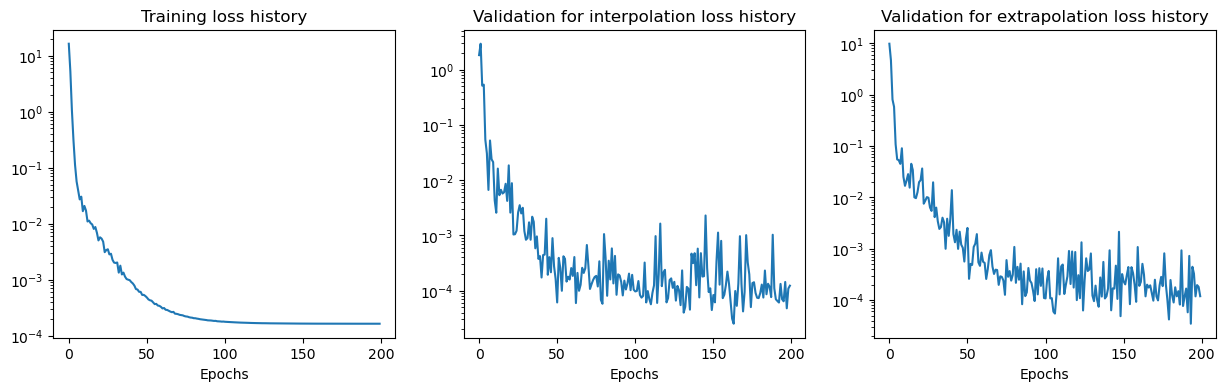

In [13]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(history["train_loss"])
plt.xlabel("Epochs")
plt.title("Training loss history")
plt.yscale('log')

plt.subplot(1,3,2)
plt.plot(history["val_interp_loss"])
plt.xlabel("Epochs")
plt.title("Validation for interpolation loss history")
plt.yscale('log')

plt.subplot(1,3,3)
plt.plot(history["val_extrap_loss"])
plt.xlabel("Epochs")
plt.title("Validation for extrapolation loss history")
plt.yscale('log')

## Predict 

In [14]:
def predict_P_U(input, P_shape, U_shape):
    # predict on the full train data (before splitting into train and validation for interpolation sets)
    output_pred = predict(input, training=False).numpy()
    P_pred = output_pred[:, 0].reshape(P_shape)
    U_pred = output_pred[:, 1].reshape(U_shape)
    return P_pred, U_pred

true_input_train_full, true_output_train_full = create_input_output(
        true_data_dict["x"],
        true_data_dict["t_train"],
        true_data_dict["P_train"],
        true_data_dict["U_train"],
    )   
# validation for extrapolation set
true_input_val_extrap, true_output_val_extrap = create_input_output(
        true_data_dict["x"],
        true_data_dict["t_val"],
        true_data_dict["P_val"],
        true_data_dict["U_val"],
    )
pred_dict = {}  
pred_dict["P_train"], pred_dict["U_train"] = predict_P_U(true_input_train_full, P_shape = true_data_dict["P_train"].shape, U_shape = true_data_dict["U_train"].shape)
pred_dict["P_val"], pred_dict["U_val"] = predict_P_U(true_input_val_extrap, P_shape = true_data_dict["P_val"].shape, U_shape = true_data_dict["U_val"].shape)

P_stack_pred = np.vstack([pred_dict["P_train"], pred_dict["P_val"]])
U_stack_pred = np.vstack([pred_dict["U_train"], pred_dict["U_val"]])

## Plot

In [15]:
def surf_plot(var, name, title, suptitle, observe = True):
    fig = plt.figure(figsize=(20,4))
    ax = fig.add_subplot(1, 4, 1, projection="3d")
    surf(fig, ax, true_data_dict["x"], true_data_dict["t_"+name], true_data_dict[var+'_'+name], "x", "t", "True "+title)
    ax = fig.add_subplot(1, 4, 2, projection="3d")
    if observe:
        surf(fig, ax, data_dict["x"], data_dict["t_"+name], data_dict[var+'_'+name], "x", "t", "Measured "+title)
    ax = fig.add_subplot(1, 4, 3, projection="3d")
    surf(fig, ax, true_data_dict["x"], true_data_dict["t_"+name], pred_dict[var+'_'+name], "x", "t", "Predicted "+title)
    ax = fig.add_subplot(1, 4, 4, projection="3d")
    surf(fig, ax, true_data_dict["x"], true_data_dict["t_"+name], true_data_dict[var+'_'+name]-pred_dict[var+'_'+name], 
        "x", "t", "Error in "+title+", (True-Predicted)")
    fig.suptitle(suptitle)
    
#surf_plot(var = "P", name = "train", title = "pressure", suptitle = f"Training set, t = {0}-{train_length}", observe=observe_p)
#surf_plot(var = "P", name = "val", title = "pressure", suptitle = f"Validation set, t = {train_length}-{train_length+val_length}", observe=observe_p)
#surf_plot(var = "U", name = "train", title = "velocity", suptitle = f"Training set, t = {0}-{train_length}", observe=observe_u)
#surf_plot(var = "U", name = "val", title = "velocity", suptitle = f"Validation set, t = {train_length}-{train_length+val_length}", observe=observe_u)

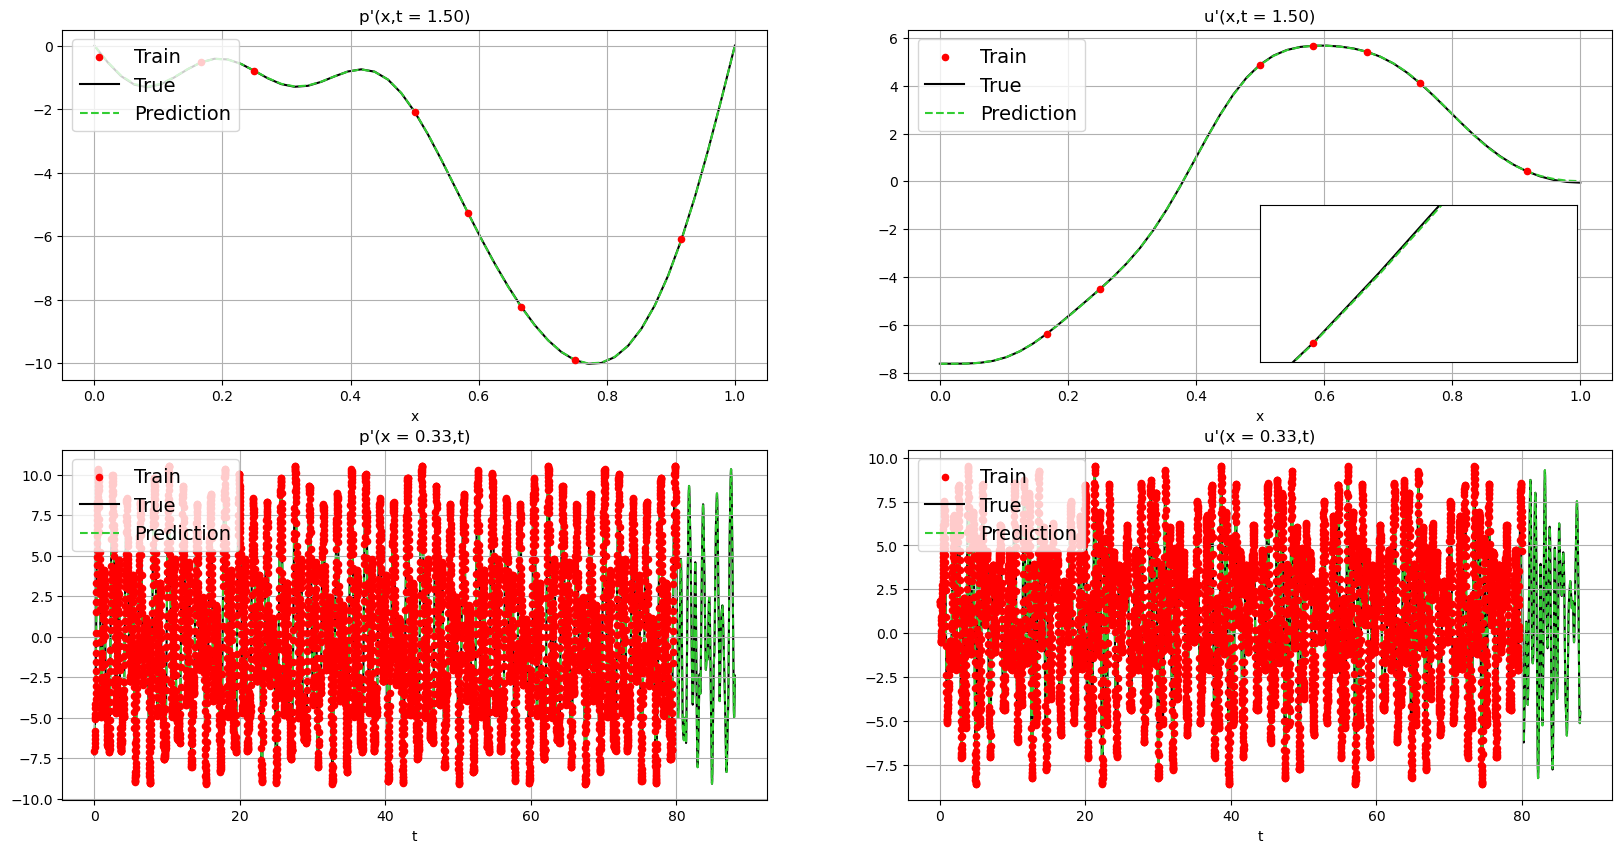

In [16]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(2, 2, 1)
plot_2d(ax,X=data_dict["x"],X_true=true_data_dict["x"],Y_idx=t_idx,idx_train=idx_train_at_t_idx,Y_idx_true=t_idx_true,
    Z=Z_p_given,Z_true=true_data_dict["P_train"],Z_pred=pred_dict["P_train"],
    xlabel="x",zlabel="",title=f"p'(x,t = {t_plot:.2f})",axis=0)

ax = fig.add_subplot(2, 2, 2)
plot_2d(ax,X=data_dict["x"],X_true=true_data_dict["x"],Y_idx=t_idx,idx_train=idx_train_at_t_idx,Y_idx_true=t_idx_true,
        Z=Z_u_given,Z_true=true_data_dict["U_train"],Z_pred=pred_dict["U_train"],
        xlabel="x",zlabel="",title=f"u'(x,t = {t_plot:.2f})",axis=0,
        add_inset=True,inset_x_lim=[0.15, 0.25],inset_y_lim=[-6.5, -5.5])

ax = fig.add_subplot(2, 2, 3)
plot_2d(ax,X=data_dict["t_train"],X_true=t_stack_true,Y_idx=x_idx,idx_train=idx_train_at_x_idx,Y_idx_true=x_idx_true,
    Z=Z_p_given,Z_true=P_stack_true,Z_pred=P_stack_pred,
    xlabel="t",zlabel="",title=f"p'(x = {x_plot:.2f},t)",axis=1)

ax = fig.add_subplot(2, 2, 4)
plot_2d(ax,X=data_dict["t_train"],X_true=t_stack_true,Y_idx=x_idx,idx_train=idx_train_at_x_idx,Y_idx_true=x_idx_true,
        Z=Z_u_given,Z_true=U_stack_true,Z_pred=U_stack_pred,
        xlabel="t",zlabel="",title=f"u'(x = {x_plot:.2f},t)",axis=1)

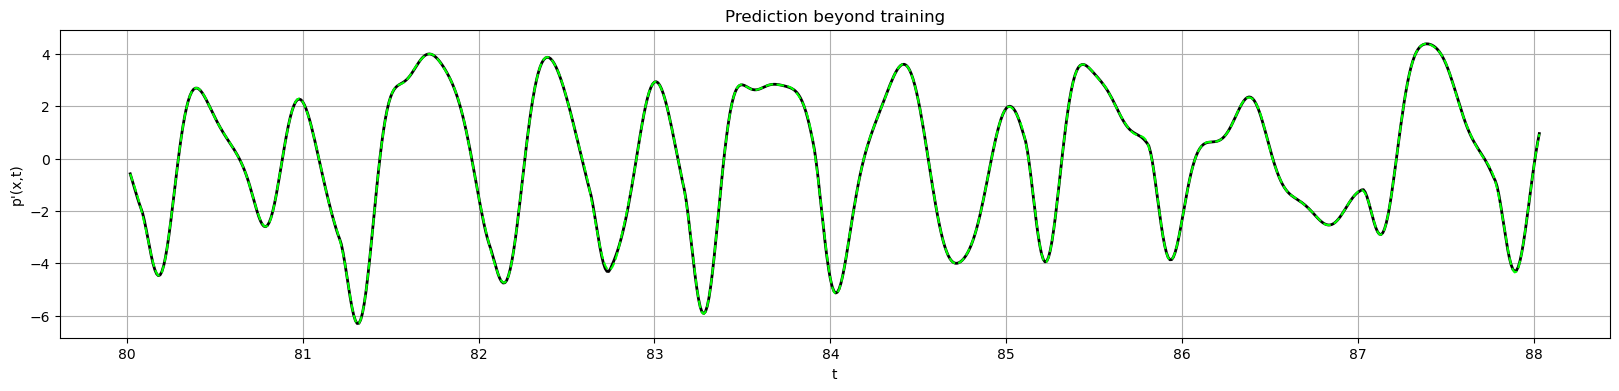

In [17]:
plt.figure(figsize = (20,4))
plt.plot(true_data_dict["t_val"], true_data_dict["P_val"][:,x_idx], color = "black", linewidth = 2)
plt.plot(true_data_dict["t_val"], pred_dict["P_val"][:,x_idx], color = "lime", linestyle = '--')
plt.xlabel("t")
plt.ylabel("p'(x,t)")
plt.grid()
plt.title("Prediction beyond training")
plt.show()